In [1]:
# import packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from pyimagesearch.preprocessing import AspectAwarePreprocessor
from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader
from pyimagesearch.nn.conv import MiniVGGNet
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import paths
import matplotlib.pyplot as plt 
import numpy as np 
import os 


In [2]:
args = {
    'dataset' : '/floyd/input/flowers_17'
}

# grab the list of images that we'll be describing, then extract
# the class label names from the image paths
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args['dataset']))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]


[INFO] loading images...


In [3]:
# load the image to the prerocessors
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensifies to range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype('float') / 255.0

# partition the data into training and testing splits using 75% training 25% testing

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

[INFO] processed 500/1360
[INFO] processed 1000/1360


In [4]:
# construct image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [5]:
# init the optimizers and model
opt = SGD(lr=0.05)
model = MiniVGGNet.build(width=64, height=64, depth=3, classes=len(classNames))
model.compile(loss='categorical_crossentropy', optimizers=opt, metrics=['accuracy'])

In [6]:
# train the network
print("[INFO] training...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32), validation_data=(testX,testY), steps_per_epoch=len(trainX) // 32, epochs=100, verbose=1)

[INFO] training...
Epoch 1/100
31/31 [==============================] - 39s 1s/step - loss: 2.7741 - accuracy: 0.2783 - val_loss: 3.1413 - val_accuracy: 0.0529
Epoch 2/100
31/31 [==============================] - 33s 1s/step - loss: 2.0755 - accuracy: 0.3988 - val_loss: 4.9906 - val_accuracy: 0.0529
Epoch 3/100
31/31 [==============================] - 33s 1s/step - loss: 1.7232 - accuracy: 0.4757 - val_loss: 6.7865 - val_accuracy: 0.0559
Epoch 4/100
31/31 [==============================] - 33s 1s/step - loss: 1.8056 - accuracy: 0.4585 - val_loss: 5.3655 - val_accuracy: 0.0971
Epoch 5/100
31/31 [==============================] - 33s 1s/step - loss: 1.6297 - accuracy: 0.5142 - val_loss: 4.3826 - val_accuracy: 0.1559
Epoch 6/100
31/31 [==============================] - 33s 1s/step - loss: 1.4221 - accuracy: 0.5638 - val_loss: 4.3497 - val_accuracy: 0.1324
Epoch 7/100
31/31 [==============================] - 33s 1s/step - loss: 1.5805 - accuracy: 0.5192 - val_loss: 4.7140 - val_accuracy: 0

[INFO] evaluating network...
              precision    recall  f1-score   support

    bluebell       0.88      0.93      0.90        15
   buttercup       0.93      0.67      0.78        21
   coltsfoot       0.39      0.63      0.48        19
     cowslip       0.43      0.75      0.55        20
      crocus       0.46      0.69      0.55        16
    daffodil       0.79      0.41      0.54        27
       daisy       0.91      0.87      0.89        23
   dandelion       0.72      0.78      0.75        23
  fritillary       0.83      0.83      0.83        18
        iris       0.82      0.61      0.70        23
  lilyvalley       0.59      0.77      0.67        22
       pansy       1.00      0.75      0.86        20
    snowdrop       0.71      0.60      0.65        20
   sunflower       0.95      0.90      0.92        20
   tigerlily       0.77      0.62      0.69        16
       tulip       0.50      0.28      0.36        18
  windflower       0.75      0.79      0.77        1

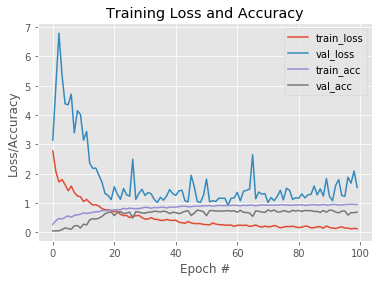

In [7]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names=classNames))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()